In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
import calendar
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.style.use('seaborn-v0_8-whitegrid')  # 使用seaborn样式

# 创建中文字体对象
font_path = 'C:/Windows/Fonts/simhei.ttf'
if os.path.exists(font_path):
    chinese_font = fm.FontProperties(fname=font_path)
    print("使用SimHei字体文件路径")
else:
    # 回退到rcParams方法
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    chinese_font = None
    print("使用rcParams设置SimHei字体")

# 创建输出目录
output_dir = 'dengue_hotspot_analysis'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 读取处理过的数据
print("=== 开始加载数据 ===")
df = pd.read_csv('../pre_data/processed_dengue_data.csv')

# 确保日期列为datetime类型
df['Date'] = pd.to_datetime(df['Date'])

print(f"原始数据形状: {df.shape}")
print(f"数据时间范围: {df['Date'].min()} 至 {df['Date'].max()}")
print("数据加载完成！\n")

使用SimHei字体文件路径
=== 开始加载数据 ===
原始数据形状: (1020, 8)
数据时间范围: 2016-01-01 00:00:00 至 2020-12-01 00:00:00
数据加载完成！



In [15]:
# 1. 创建地区-月份热图
print("1. 创建地区-月份热图")

# 1.1 计算平均病例数的热图数据
print("  计算平均值热图数据...")
# 按地区和月份计算平均病例数
monthly_region_cases = df.groupby(['Region', 'MonthNum'])['Dengue_Cases'].mean().reset_index()

# 转换为透视表格式以便于热图可视化
monthly_region_pivot = monthly_region_cases.pivot(index='Region', columns='MonthNum', values='Dengue_Cases')

# 1.2 按总病例数对地区排序
print("  按总病例数对地区排序...")
region_total_cases = df.groupby('Region')['Dengue_Cases'].sum().sort_values(ascending=False)
sorted_regions = region_total_cases.index.tolist()

# 重新排序热图数据
monthly_region_pivot = monthly_region_pivot.reindex(sorted_regions)

# 1.3 创建热图
print("  创建平均值热图...")
plt.figure(figsize=(14, 10))
ax = sns.heatmap(monthly_region_pivot, cmap='YlOrRd', annot=True, fmt='.0f')

if chinese_font is not None:
    plt.title('菲律宾各地区月度登革热病例平均值（2016-2020）', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区（按总病例数排序）', fontproperties=chinese_font, fontsize=12)
    # 设置x轴标签为月份名称
    month_names = ['一月', '二月', '三月', '四月', '五月', '六月', 
                  '七月', '八月', '九月', '十月', '十一月', '十二月']
    ax.set_xticklabels(month_names, fontproperties=chinese_font)
else:
    plt.title('菲律宾各地区月度登革热病例平均值（2016-2020）', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('地区（按总病例数排序）', fontsize=12)
    # 设置x轴标签为月份名称
    month_names = ['一月', '二月', '三月', '四月', '五月', '六月', 
                  '七月', '八月', '九月', '十月', '十一月', '十二月']
    ax.set_xticklabels(month_names)

plt.tight_layout()
plt.savefig(f'{output_dir}/region_month_heatmap_avg.png', dpi=300)
print(f"  保存图表：{output_dir}/region_month_heatmap_avg.png")
plt.close()

# 1.4 创建标准化热图（Z-score）
print("  创建标准化热图...")
normalized_pivot = monthly_region_pivot.copy()
for idx in normalized_pivot.index:
    row = normalized_pivot.loc[idx]
    mean = row.mean()
    std = row.std()
    if std != 0:  # 避免除以零
        normalized_pivot.loc[idx] = (row - mean) / std
    else:
        normalized_pivot.loc[idx] = 0  # 如果标准差为0，则设置为0

plt.figure(figsize=(14, 10))
ax = sns.heatmap(normalized_pivot, cmap='coolwarm', center=0, annot=True, fmt='.1f')

if chinese_font is not None:
    plt.title('菲律宾各地区月度登革热病例标准化热图（Z-score）', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区（按总病例数排序）', fontproperties=chinese_font, fontsize=12)
    ax.set_xticklabels(month_names, fontproperties=chinese_font)
else:
    plt.title('菲律宾各地区月度登革热病例标准化热图（Z-score）', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('地区（按总病例数排序）', fontsize=12)
    ax.set_xticklabels(month_names)

plt.tight_layout()
plt.savefig(f'{output_dir}/region_month_heatmap_zscore.png', dpi=300)
print(f"  保存图表：{output_dir}/region_month_heatmap_zscore.png")
plt.close()

# 1.5 创建按年份和月份的热图
print("  创建年份-月份热图...")
# 按年份和月份计算全国总病例数
yearly_monthly_cases = df.groupby(['Year', 'MonthNum'])['Dengue_Cases'].sum().reset_index()
yearly_monthly_pivot = yearly_monthly_cases.pivot(index='Year', columns='MonthNum', values='Dengue_Cases')

plt.figure(figsize=(12, 6))
ax = sns.heatmap(yearly_monthly_pivot, cmap='YlOrRd', annot=True, fmt='.0f')

if chinese_font is not None:
    plt.title('菲律宾年度和月度登革热病例热图（2016-2020）', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('年份', fontproperties=chinese_font, fontsize=12)
    ax.set_xticklabels(month_names, fontproperties=chinese_font)
else:
    plt.title('菲律宾年度和月度登革热病例热图（2016-2020）', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('年份', fontsize=12)
    ax.set_xticklabels(month_names)

plt.tight_layout()
plt.savefig(f'{output_dir}/year_month_heatmap.png', dpi=300)
print(f"  保存图表：{output_dir}/year_month_heatmap.png")
plt.close()


1. 创建地区-月份热图
  计算平均值热图数据...
  按总病例数对地区排序...
  创建平均值热图...
  保存图表：dengue_hotspot_analysis/region_month_heatmap_avg.png
  创建标准化热图...
  保存图表：dengue_hotspot_analysis/region_month_heatmap_zscore.png
  创建年份-月份热图...
  保存图表：dengue_hotspot_analysis/year_month_heatmap.png


In [22]:
# 2. 分析高峰月份的地区分布
print("\n2. 分析高峰月份的地区分布")

# 2.1 确定每个地区的高峰月份
print("  确定各地区高峰月份...")
peak_months = monthly_region_cases.loc[monthly_region_cases.groupby('Region')['Dengue_Cases'].idxmax()]
peak_months['Month'] = peak_months['MonthNum'].apply(lambda x: month_names[x-1])

# 统计各月份作为高峰月的地区数量
peak_month_counts = peak_months['MonthNum'].value_counts().sort_index()
peak_month_counts.index = [month_names[i-1] for i in peak_month_counts.index]

# 2.2 可视化高峰月份分布
print("  可视化高峰月份分布...")
plt.figure(figsize=(12, 6))
bars = plt.bar(peak_month_counts.index, peak_month_counts.values, color='orange')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.0f}', ha='center', va='bottom')

if chinese_font is not None:
    plt.title('各地区登革热病例高峰月份分布', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区数量', fontproperties=chinese_font, fontsize=12)
else:
    plt.title('各地区登革热病例高峰月份分布', fontsize=16)
    plt.xlabel('月份', fontsize=12, fontproperties=chinese_font)
    plt.ylabel('地区数量', fontsize=12, fontproperties=chinese_font)

plt.xticks(rotation=45, fontproperties=chinese_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(f'{output_dir}/peak_month_distribution.png', dpi=300)
print(f"  保存图表：{output_dir}/peak_month_distribution.png")
plt.close()

# 2.3 分析各地区在高峰月的病例占比
print("  分析高峰月病例占比...")
# 计算每个地区在高峰月的病例数占全年的比例
region_monthly_sum = df.groupby(['Region', 'MonthNum'])['Dengue_Cases'].sum().reset_index()
region_total = df.groupby('Region')['Dengue_Cases'].sum().reset_index()

# 合并数据
region_monthly_sum = pd.merge(region_monthly_sum, region_total, on='Region', suffixes=('_month', '_total'))
region_monthly_sum['Percentage'] = (region_monthly_sum['Dengue_Cases_month'] / region_monthly_sum['Dengue_Cases_total']) * 100

# 提取每个地区的高峰月份数据
peak_month_percentages = []
for region in sorted_regions:
    region_data = region_monthly_sum[region_monthly_sum['Region'] == region]
    peak_month_row = region_data.loc[region_data['Dengue_Cases_month'].idxmax()]
    peak_month_num = peak_month_row['MonthNum']
    peak_month_name = month_names[peak_month_num-1]
    peak_percentage = peak_month_row['Percentage']
    peak_month_percentages.append({
        'Region': region,
        'Peak_Month_Num': peak_month_num,
        'Peak_Month': peak_month_name,
        'Peak_Percentage': peak_percentage
    })

peak_percentages_df = pd.DataFrame(peak_month_percentages)
peak_percentages_df = peak_percentages_df.sort_values('Peak_Percentage', ascending=False)

# 可视化高峰月份病例占比
plt.figure(figsize=(14, 10))
bars = plt.barh(peak_percentages_df['Region'], peak_percentages_df['Peak_Percentage'], 
               color=[plt.cm.tab10(i % 10) for i in range(len(peak_percentages_df))])

# 添加高峰月份标签
for i, (region, percentage, month) in enumerate(zip(
    peak_percentages_df['Region'], peak_percentages_df['Peak_Percentage'], peak_percentages_df['Peak_Month'])):
    plt.text(percentage + 0.5, i, f"{percentage:.1f}% ({month})", va='center', fontproperties=chinese_font)

if chinese_font is not None:
    plt.title('各地区高峰月份病例占全年总病例的百分比', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('高峰月份病例占比 (%)', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区', fontproperties=chinese_font, fontsize=12)
else:
    plt.title('各地区高峰月份病例占全年总病例的百分比', fontsize=16, fontproperties=chinese_font)
    plt.xlabel('高峰月份病例占比 (%)', fontsize=12, fontproperties=chinese_font)
    plt.ylabel('地区', fontsize=12, fontproperties=chinese_font)

plt.xlim(0, max(peak_percentages_df['Peak_Percentage']) * 1.1)
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(f'{output_dir}/peak_month_percentage.png', dpi=300)
print(f"  保存图表：{output_dir}/peak_month_percentage.png")
plt.close()


2. 分析高峰月份的地区分布
  确定各地区高峰月份...
  可视化高峰月份分布...
  保存图表：dengue_hotspot_analysis/peak_month_distribution.png
  分析高峰月病例占比...
  保存图表：dengue_hotspot_analysis/peak_month_percentage.png


In [23]:
# 3. 识别时空热点模式
print("\n3. 识别时空热点模式")

# 3.1 定义热点识别函数
print("  定义热点识别函数...")
def identify_hotspots(data, zscore_threshold=1.5):
    """
    识别时空热点，返回高于指定Z-score阈值的数据点
    
    参数:
    data: 包含Region, MonthNum和Z-Score的DataFrame
    zscore_threshold: Z-score阈值，默认为1.5
    
    返回:
    热点数据
    """
    return data[data['Z_Score'] > zscore_threshold]

# 3.2 计算Z-score并识别热点
print("  计算Z-score并识别热点...")
# 展平透视表
normalized_data = normalized_pivot.stack().reset_index()
normalized_data.columns = ['Region', 'MonthNum', 'Z_Score']

# 识别热点
hotspots = identify_hotspots(normalized_data)
print(f"  识别到{len(hotspots)}个热点")

# 添加月份名称
hotspots['Month'] = hotspots['MonthNum'].apply(lambda x: month_names[x-1])

# 3.3 热点分布可视化
print("  可视化热点分布...")
plt.figure(figsize=(14, 10))

# 热点散点图
plt.scatter(hotspots['MonthNum'], hotspots['Region'], s=100, c=hotspots['Z_Score'], 
           cmap='Reds', alpha=0.7, edgecolors='black')

# 添加背景热图
plt.imshow(normalized_pivot, cmap='Blues', alpha=0.3, aspect='auto', 
          extent=[0.5, 12.5, -0.5, len(normalized_pivot)-0.5])

# 添加颜色条
cbar = plt.colorbar()
if chinese_font is not None:
    cbar.set_label('Z-Score', fontproperties=chinese_font)
else:
    cbar.set_label('Z-Score')

if chinese_font is not None:
    plt.title('登革热时空热点分布（Z-Score > 1.5）', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区', fontproperties=chinese_font, fontsize=12)
    plt.xticks(range(1, 13), month_names, fontproperties=chinese_font, rotation=45)
else:
    plt.title('登革热时空热点分布（Z-Score > 1.5）', fontsize=16)
    plt.xlabel('月份', fontsize=12, fontproperties=chinese_font)
    plt.ylabel('地区', fontsize=12, fontproperties=chinese_font)
    plt.xticks(range(1, 13), month_names, rotation=45)

plt.grid(False)
plt.tight_layout()
plt.savefig(f'{output_dir}/hotspot_distribution.png', dpi=300)
print(f"  保存图表：{output_dir}/hotspot_distribution.png")
plt.close()

# 3.4 创建热点频率表
print("  创建热点频率表...")
hotspot_freq = hotspots.groupby(['Region', 'Month']).size().reset_index()
hotspot_freq.columns = ['Region', 'Month', 'Hotspot_Count']

# 保存热点频率表
hotspot_freq.to_csv(f'{output_dir}/hotspot_frequency.csv', index=False)
print(f"  热点频率表已保存至: {output_dir}/hotspot_frequency.csv")

# 3.5 识别持续性热点
print("  识别持续性热点...")
# 按地区和年份统计热点月份数量
hotspot_yearly = pd.merge(hotspots, df[['Region', 'MonthNum', 'Year']].drop_duplicates(), 
                         on=['Region', 'MonthNum'])
persistent_hotspots = hotspot_yearly.groupby(['Region', 'Year']).size().reset_index()
persistent_hotspots.columns = ['Region', 'Year', 'Hotspot_Months']
persistent_regions = persistent_hotspots[persistent_hotspots['Hotspot_Months'] >= 3].groupby('Region').size()
persistent_regions = persistent_regions.sort_values(ascending=False)

print(f"  持续性热点地区 (至少3个月/年):")
for region, years in persistent_regions.items():
    print(f"    {region}: {years}年出现持续热点")


3. 识别时空热点模式
  定义热点识别函数...
  计算Z-score并识别热点...
  识别到23个热点
  可视化热点分布...
  保存图表：dengue_hotspot_analysis/hotspot_distribution.png
  创建热点频率表...
  热点频率表已保存至: dengue_hotspot_analysis/hotspot_frequency.csv
  识别持续性热点...
  持续性热点地区 (至少3个月/年):


In [29]:
# 1. 分析热点变化的时间趋势
print("1. 分析热点变化的时间趋势")

# 1.1 按年度分析热点变化
print("  分析年度热点变化...")
# 合并热点数据与年份信息
hotspot_by_year = pd.merge(hotspots, df[['Region', 'MonthNum', 'Year']].drop_duplicates(), 
                          on=['Region', 'MonthNum'])

# 按年份统计热点数
yearly_hotspots = hotspot_by_year.groupby('Year').size().reset_index()
yearly_hotspots.columns = ['Year', 'Hotspot_Count']

# 可视化年度热点变化
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_hotspots['Year'], yearly_hotspots['Hotspot_Count'], color='darkred')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.0f}', ha='center', va='bottom')

if chinese_font is not None:
    plt.title('登革热热点的年度变化趋势', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('年份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('热点数量', fontproperties=chinese_font, fontsize=12)
else:
    plt.title('登革热热点的年度变化趋势', fontsize=16)
    plt.xlabel('年份', fontsize=12, fontproperties=chinese_font)
    plt.ylabel('热点数量', fontsize=12, fontproperties=chinese_font)

plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(f'{output_dir}/yearly_hotspot_trend.png', dpi=300)
print(f"  保存图表：{output_dir}/yearly_hotspot_trend.png")
plt.close()

# 1.2 分析热点的季节性变化
print("  分析热点的季节性变化...")
# 按月份统计热点数
monthly_hotspots = hotspots.groupby('MonthNum').size().reset_index()
monthly_hotspots.columns = ['MonthNum', 'Hotspot_Count']
monthly_hotspots['Month'] = monthly_hotspots['MonthNum'].apply(lambda x: month_names[x-1])
monthly_hotspots = monthly_hotspots.sort_values('MonthNum')

plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_hotspots['Month'], monthly_hotspots['Hotspot_Count'], color='orange')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.0f}', ha='center', va='bottom')

if chinese_font is not None:
    plt.title('登革热热点的月度分布', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('热点数量', fontproperties=chinese_font, fontsize=12)
else:
    plt.title('登革热热点的月度分布', fontsize=16)
    plt.xlabel('月份', fontsize=12, fontproperties=chinese_font)
    plt.ylabel('热点数量', fontsize=12, fontproperties=chinese_font)

plt.xticks(rotation=45, fontproperties=chinese_font)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(f'{output_dir}/monthly_hotspot_distribution.png', dpi=300)
print(f"  保存图表：{output_dir}/monthly_hotspot_distribution.png")
plt.close()

# 1.3 分析热点的地区分布变化
print("  分析热点的地区分布变化...")
# 按地区统计热点数
region_hotspots = hotspots.groupby('Region').size().reset_index()
region_hotspots.columns = ['Region', 'Hotspot_Count']
region_hotspots = region_hotspots.sort_values('Hotspot_Count', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.barh(region_hotspots['Region'], region_hotspots['Hotspot_Count'], 
               color=[plt.cm.Reds(count/max(region_hotspots['Hotspot_Count'])) 
                     for count in region_hotspots['Hotspot_Count']])

# 添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.1, i, f'{width:.0f}', va='center')

if chinese_font is not None:
    plt.title('各地区登革热热点数量', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('热点数量', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区', fontproperties=chinese_font, fontsize=12)
else:
    plt.title('各地区登革热热点数量', fontsize=16)
    plt.xlabel('热点数量', fontsize=12)
    plt.ylabel('地区', fontsize=12)

plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(f'{output_dir}/region_hotspot_count.png', dpi=300)
print(f"  保存图表：{output_dir}/region_hotspot_count.png")
plt.close()

# 1.4 时空热点演变
print("  分析时空热点演变...")
# 创建按年份和月份的热点分布热图
yearly_monthly_hotspots = hotspot_by_year.groupby(['Year', 'MonthNum']).size().reset_index()
yearly_monthly_hotspots.columns = ['Year', 'MonthNum', 'Hotspot_Count']
yearly_monthly_pivot = yearly_monthly_hotspots.pivot(index='Year', columns='MonthNum', values='Hotspot_Count')
yearly_monthly_pivot = yearly_monthly_pivot.fillna(0)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(yearly_monthly_pivot, cmap='YlOrRd', annot=True, fmt='.0f')

if chinese_font is not None:
    plt.title('登革热热点的年度-月度演变', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('年份', fontproperties=chinese_font, fontsize=12)
    plt.xticks(np.arange(12), month_names)
    ax.set_xticklabels(month_names, fontproperties=chinese_font)
else:
    plt.title('登革热热点的年度-月度演变', fontsize=16)
    plt.xlabel('月份', fontsize=12, fontproperties=chinese_font)
    plt.ylabel('年份', fontsize=12, fontproperties=chinese_font)
    ax.set_xticklabels(month_names)

plt.tight_layout()
plt.savefig(f'{output_dir}/yearly_monthly_hotspot_evolution.png', dpi=300)
print(f"  保存图表：{output_dir}/yearly_monthly_hotspot_evolution.png")
plt.close()


1. 分析热点变化的时间趋势
  分析年度热点变化...
  保存图表：dengue_hotspot_analysis/yearly_hotspot_trend.png
  分析热点的季节性变化...
  保存图表：dengue_hotspot_analysis/monthly_hotspot_distribution.png
  分析热点的地区分布变化...
  保存图表：dengue_hotspot_analysis/region_hotspot_count.png
  分析时空热点演变...
  保存图表：dengue_hotspot_analysis/yearly_monthly_hotspot_evolution.png


In [27]:
# 2. 确定重点监测地区和时间
print("\n2. 确定重点监测地区和时间")

# 2.1 基于热点频率确定重点监测地区
print("  确定重点监测地区...")
# 按热点数量选择前5个地区
top_regions = region_hotspots.head(5)['Region'].tolist()
print(f"  前5个热点频繁地区: {', '.join(top_regions)}")

# 2.2 基于热点频率确定重点监测月份
print("  确定重点监测月份...")
# 按热点数量选择前4个月份
top_months = monthly_hotspots.sort_values('Hotspot_Count', ascending=False).head(4)
print("  前4个热点频繁月份:")
for _, row in top_months.iterrows():
    print(f"    {row['Month']}: {row['Hotspot_Count']}个热点")

# 2.3 按年度分析各地区热点变化
print("  分析各地区热点年度趋势...")
# 按地区和年份统计热点
region_year_hotspots = hotspot_by_year.groupby(['Region', 'Year']).size().reset_index()
region_year_hotspots.columns = ['Region', 'Year', 'Hotspot_Count']

# 仅选择前5个热点地区进行可视化
top_region_trends = region_year_hotspots[region_year_hotspots['Region'].isin(top_regions)]

plt.figure(figsize=(12, 8))
for region in top_regions:
    region_data = top_region_trends[top_region_trends['Region'] == region]
    plt.plot(region_data['Year'], region_data['Hotspot_Count'], marker='o', linewidth=2, label=region)

if chinese_font is not None:
    plt.title('前5个热点地区的年度趋势', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('年份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('热点数量', fontproperties=chinese_font, fontsize=12)
    plt.legend(prop=chinese_font)
else:
    plt.title('前5个热点地区的年度趋势', fontsize=16)
    plt.xlabel('年份', fontsize=12)
    plt.ylabel('热点数量', fontsize=12)
    plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/top_regions_yearly_trend.png', dpi=300)
print(f"  保存图表：{output_dir}/top_regions_yearly_trend.png")
plt.close()

# 2.4 创建重点监测时间表
print("  创建重点监测时间表...")
# 创建重点监测的地区-月份组合
priority_monitoring = pd.DataFrame(columns=['Region', 'Month', 'Priority_Level', 'Reasoning'])

# 添加顶级优先级（前5个地区的前4个高发月份）
row_id = 0
for region in top_regions:
    region_data = monthly_region_cases[monthly_region_cases['Region'] == region]
    top_months_for_region = region_data.sort_values('Dengue_Cases', ascending=False).head(4)
    for _, month_row in top_months_for_region.iterrows():
        month_name = month_names[month_row['MonthNum']-1]
        priority_monitoring.loc[row_id] = [
            region, 
            month_name, 
            'A - 最高优先级', 
            f"热点频繁地区的高发月份，平均病例数 {month_row['Dengue_Cases']:.0f}"
        ]
        row_id += 1

# 保存重点监测时间表
priority_monitoring.to_csv(f'{output_dir}/priority_monitoring_schedule.csv', index=False)
print(f"  重点监测时间表已保存至: {output_dir}/priority_monitoring_schedule.csv")


2. 确定重点监测地区和时间
  确定重点监测地区...
  前5个热点频繁地区: CAR, Region I, Region III, Region V, Region XI
  确定重点监测月份...
  前4个热点频繁月份:
    八月: 10个热点
    九月: 7个热点
    七月: 5个热点
    一月: 1个热点
  分析各地区热点年度趋势...
  保存图表：dengue_hotspot_analysis/top_regions_yearly_trend.png
  创建重点监测时间表...
  重点监测时间表已保存至: dengue_hotspot_analysis/priority_monitoring_schedule.csv



3. 整理热点分析结果
  生成热点分析摘要...
  热点分析摘要已保存至: dengue_hotspot_analysis/hotspot_analysis_summary.md
  创建热点强度地图...


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (12).

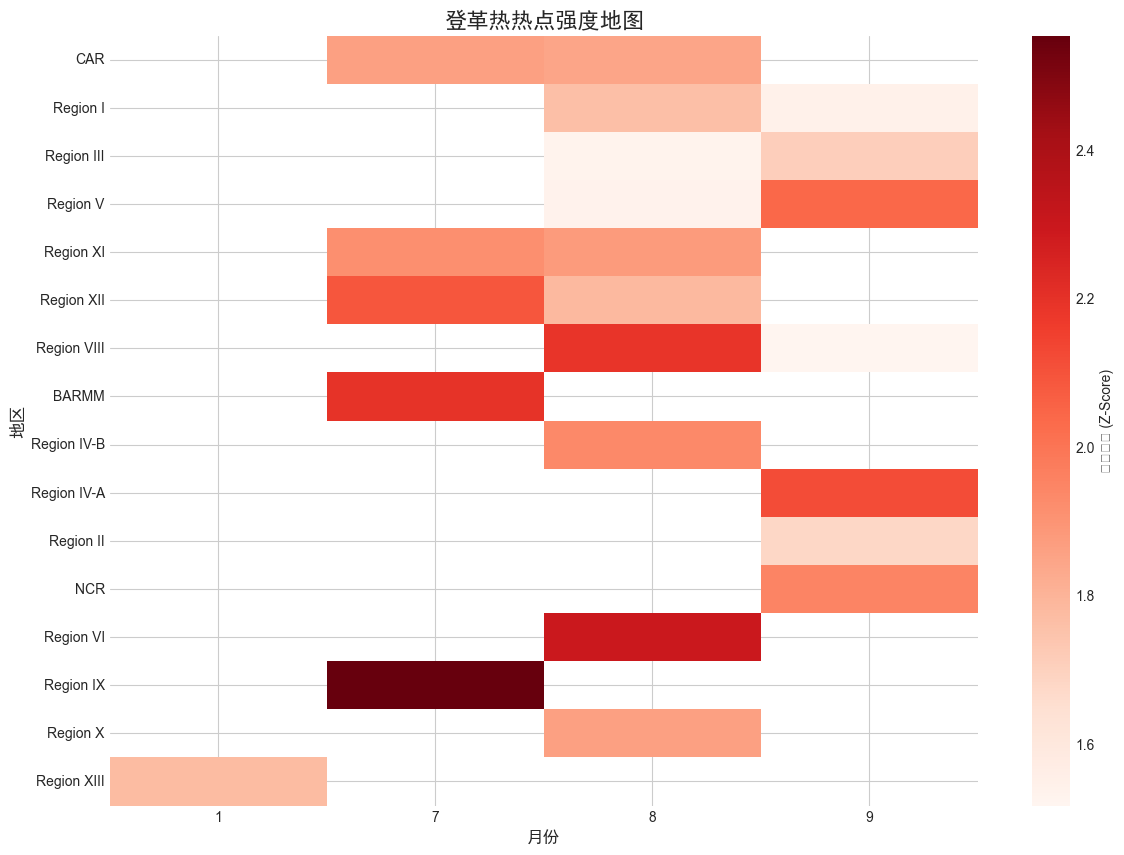

In [30]:
# 3. 整理热点分析结果
print("\n3. 整理热点分析结果")

# 3.1 生成热点分析摘要
print("  生成热点分析摘要...")
summary = f"""# 菲律宾登革热时空热点分析

## 热点分析概述

- **分析时间范围**: {df['Date'].min().strftime('%Y-%m-%d')} 至 {df['Date'].max().strftime('%Y-%m-%d')}
- **识别到的热点总数**: {len(hotspots)}
- **热点判定标准**: Z-Score > 1.5 (相对于各地区的月度平均值)

## 热点时间分布

以下月份出现热点频率最高:

"""

for _, row in top_months.iterrows():
    summary += f"- **{row['Month']}**: {row['Hotspot_Count']}个热点\n"

summary += """
## 热点地区分布

以下地区出现热点频率最高:

"""

for _, row in region_hotspots.head(5).iterrows():
    summary += f"- **{row['Region']}**: {row['Hotspot_Count']}个热点\n"

summary += """
## 热点随时间变化趋势

"""

# 添加年度趋势描述
max_year = yearly_hotspots.loc[yearly_hotspots['Hotspot_Count'].idxmax()]['Year']
min_year = yearly_hotspots.loc[yearly_hotspots['Hotspot_Count'].idxmin()]['Year']
summary += f"- **热点数量最多的年份**: {max_year}年 ({yearly_hotspots[yearly_hotspots['Year'] == max_year]['Hotspot_Count'].values[0]}个热点)\n"
summary += f"- **热点数量最少的年份**: {min_year}年 ({yearly_hotspots[yearly_hotspots['Year'] == min_year]['Hotspot_Count'].values[0]}个热点)\n\n"

# 添加持续性热点描述
summary += "## 持续性热点地区\n\n"
summary += "以下地区在多个年份内都出现了持续性热点 (每年至少3个月):\n\n"

for region, years in persistent_regions.head(5).items():
    summary += f"- **{region}**: {years}年出现持续热点\n"

summary += """
## 重点监测建议

### 推荐重点监测的地区-月份组合

"""

for region in top_regions:
    summary += f"### {region}:\n\n"
    region_priorities = priority_monitoring[priority_monitoring['Region'] == region]
    for _, row in region_priorities.iterrows():
        summary += f"- **{row['Month']}**: {row['Reasoning']}\n"
    summary += "\n"

summary += """
## 时空热点模式总结

1. 登革热在菲律宾存在明显的季节性模式，7-10月为主要热点时期。

2. 部分地区在非典型月份也会出现热点，需特别关注这些异常模式。

3. 热点地区主要集中在几个高风险区域，但热点强度和持续性各异。

4. 年度间热点分布存在波动，反映了登革热疫情的周期性特点。

5. 需将监测资源集中在高频热点地区和时间，同时对异常热点保持警惕。
"""

# 保存热点分析摘要
with open(f'{output_dir}/hotspot_analysis_summary.md', 'w', encoding='utf-8') as f:
    f.write(summary)
print(f"  热点分析摘要已保存至: {output_dir}/hotspot_analysis_summary.md")

# 3.2 创建热点强度地图
print("  创建热点强度地图...")
# 按地区和月份计算热点强度（使用Z-Score的平均值）
hotspot_intensity = hotspots.groupby(['Region', 'MonthNum'])['Z_Score'].mean().reset_index()
hotspot_intensity_pivot = hotspot_intensity.pivot(index='Region', columns='MonthNum', values='Z_Score')
hotspot_intensity_pivot = hotspot_intensity_pivot.fillna(0)

# 按热点数排序
hotspot_intensity_pivot = hotspot_intensity_pivot.reindex(region_hotspots['Region'])

plt.figure(figsize=(14, 10))
ax = sns.heatmap(hotspot_intensity_pivot, cmap='Reds', mask=(hotspot_intensity_pivot == 0), 
                cbar_kws={'label': '热点强度 (Z-Score)'})

if chinese_font is not None:
    plt.title('登革热热点强度地图', fontproperties=chinese_font, fontsize=16)
    plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
    plt.ylabel('地区', fontproperties=chinese_font, fontsize=12)
    ax.set_xticklabels(month_names, fontproperties=chinese_font)
    cbar = ax.collections[0].colorbar
    cbar.set_label('热点强度 (Z-Score)', fontproperties=chinese_font)
else:
    plt.title('登革热热点强度地图', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('地区', fontsize=12)
    ax.set_xticklabels(month_names)

plt.tight_layout()
plt.savefig(f'{output_dir}/hotspot_intensity_map.png', dpi=300)
print(f"  保存图表：{output_dir}/hotspot_intensity_map.png")
plt.close()

# 3.3 创建时空热点传播可视化
print("  创建时空热点传播可视化...")
# 按年份和月份绘制热点的变化趋势
for year in df['Year'].unique():
    # 提取该年的热点
    year_hotspots = hotspot_by_year[hotspot_by_year['Year'] == year]
    if len(year_hotspots) == 0:
        continue
    
    # 创建该年的热点分布热图
    year_pivot = pd.pivot_table(
        year_hotspots, 
        values='Z_Score', 
        index='Region', 
        columns='MonthNum', 
        aggfunc='mean',
        fill_value=0
    )
    
    # 只保留有热点的地区
    year_pivot = year_pivot[(year_pivot > 0).any(axis=1)]
    
    plt.figure(figsize=(14, 10))
    ax = sns.heatmap(year_pivot, cmap='Reds', mask=(year_pivot == 0),
                    cbar_kws={'label': '热点强度 (Z-Score)'})
    
    if chinese_font is not None:
        plt.title(f'{year}年登革热热点分布', fontproperties=chinese_font, fontsize=16)
        plt.xlabel('月份', fontproperties=chinese_font, fontsize=12)
        plt.ylabel('地区', fontproperties=chinese_font, fontsize=12)
        ax.set_xticklabels(month_names, fontproperties=chinese_font)
        cbar = ax.collections[0].colorbar
        cbar.set_label('热点强度 (Z-Score)', fontproperties=chinese_font)
    else:
        plt.title(f'{year}年登革热热点分布', fontsize=16)
        plt.xlabel('月份', fontsize=12)
        plt.ylabel('地区', fontsize=12)
        ax.set_xticklabels(month_names)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/hotspot_map_{year}.png', dpi=300)
    print(f"  保存图表：{output_dir}/hotspot_map_{year}.png")
    plt.close()